# Add ELAs from AARs to snowline files

In [7]:
import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import ee
import sys

In [8]:
# -----Define paths in directory
# path to study-sites
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils as f

In [12]:
# -----Initialize GEE account
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except: 
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [46]:
# -----Grab list of site names in study_sites_path
site_names = sorted(os.listdir(study_sites_path))
site_names = [x for x in site_names if not x.startswith('.')]
# don't include BGOTUS (already done)
bgotus_site_names = ['Wolverine', 'LemonCreek', 'Gulkana', 'SouthCascade', 'Sperry']
site_names = [x for x in site_names if x not in bgotus_site_names]
site_names

['Blue',
 'Boulder',
 'Carbon',
 'Coleman',
 'Easton',
 'Emmons',
 'Hidden',
 'Hoh',
 'RGI60-01.00037',
 'RGI60-01.00038',
 'RGI60-01.00046',
 'RGI60-01.00312',
 'RGI60-01.00566',
 'RGI60-01.00576',
 'RGI60-01.01151',
 'RGI60-01.01390',
 'RGI60-01.01524',
 'RGI60-01.01733',
 'RGI60-01.03861',
 'RGI60-01.04375',
 'RGI60-01.06268',
 'RGI60-01.06722',
 'RGI60-01.08155',
 'RGI60-01.08174',
 'RGI60-01.08246',
 'RGI60-01.08248',
 'RGI60-01.08262',
 'RGI60-01.08288',
 'RGI60-01.08296',
 'RGI60-01.08302',
 'RGI60-01.08336',
 'RGI60-01.08353',
 'RGI60-01.08389',
 'RGI60-01.08395',
 'RGI60-01.08403',
 'RGI60-01.08412',
 'RGI60-01.08427',
 'RGI60-01.09148',
 'RGI60-01.09216',
 'RGI60-01.09411',
 'RGI60-01.09639',
 'RGI60-01.10196',
 'RGI60-01.10555',
 'RGI60-01.10689',
 'RGI60-01.10778',
 'RGI60-01.10851',
 'RGI60-01.10857',
 'RGI60-01.11616',
 'RGI60-01.11654',
 'RGI60-01.11788',
 'RGI60-01.12370',
 'RGI60-01.12425',
 'RGI60-01.12635',
 'RGI60-01.13696',
 'RGI60-01.14391',
 'RGI60-01.14443',
 'R

In [ ]:
# iterate over site names
for site_name in tqdm(site_names[16:]):
    
    print(site_name)
    
    # Load snowline file names
    snowlines_path = study_sites_path + site_name + '/imagery/snowlines/'
    snowline_fns = [os.path.basename(x) for x in glob.glob(snowlines_path + '*.csv')]
    if len(snowline_fns)<1:
        continue
    
    # Load AOI
    AOI_path = study_sites_path + site_name + '/AOIs/'
    AOI_fn = glob.glob(AOI_path + '*_outline.shp')[0]
    AOI = gpd.read_file(AOI_fn)
    AOI_WGS = AOI.to_crs('EPSG:4326')
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                        AOI_WGS.geometry[0].centroid.xy[1][0]]
    # grab the optimal UTM zone EPSG code
    epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
    # reproject AOI to the optimal UTM zone
    AOI_UTM = AOI.to_crs('EPSG:'+epsg_UTM)

    # Load DEM, clip to AOI
    DEM_path = study_sites_path + site_name + '/DEMs/'
    # DEM_fn = glob.glob(DEM_path + '*USGS*.tif')[0]
    # DEM = rxr.open_rasterio(DEM_fn)
    DEM = f.query_gee_for_dem(AOI_UTM, base_path, site_name, DEM_path)   
    DEM_clip = DEM.rio.clip(AOI_UTM.geometry, 'EPSG:' + str(epsg_UTM))
    # DEM_clip = xr.where(DEM_clip<500, np.nan, DEM_clip)
    elevations = np.ravel(DEM_clip.elevation.data)    
    
    # iterate over snowline files
    for snowline_fn in tqdm(snowline_fns):
                        
        # load snowline
        try:
            snowline = pd.read_csv(snowlines_path + snowline_fn)
        except:
            continue
            
        cols = snowline.columns.tolist()
        # if 'ELA_from_AAR_m' in cols:
        #     # print('column already exists, skipping...')
        #     # print(' ')
        #     continue

        # calculate ELA from AAR
        aar = snowline['AAR'].values[0]
        ela_from_aar = np.nanquantile(elevations, 1 - aar)

        # add to snowline dataframe
        snowline['ELA_from_AAR_m'] = ela_from_aar

        # remove any "Unnamed" columns
        cols = snowline.columns.tolist()
        cols = [x for x in cols if "Unnamed" not in x]
        snowline = snowline[cols]
                
        # save to file
        snowline.to_csv(snowlines_path + snowline_fn, index=False)
        
    print(' ')
                
    

  0%|          | 0/129 [00:00<?, ?it/s]

RGI60-01.01524
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.01524_ArcticDEM_clip.tif download size (raw: 3.75 GB).


RGI60-01.01524_ArcticDEM_clip.tif: | | 0.00/3.75G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/146 [00:00<?, ?it/s]

 
RGI60-01.01733
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.01733_ArcticDEM_clip.tif download size (raw: 1.21 GB).


RGI60-01.01733_ArcticDEM_clip.tif: | | 0.00/1.21G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/269 [00:00<?, ?it/s]

 
RGI60-01.03861
RGI60-01.04375
RGI60-01.06268
RGI60-01.06722
RGI60-01.08155
RGI60-01.08174
RGI60-01.08246
ArcticDEM coverage over AOI


RGI60-01.08246_ArcticDEM_clip.tif: | | 0.00/164M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/122 [00:00<?, ?it/s]

 
RGI60-01.08248
ArcticDEM coverage over AOI


RGI60-01.08248_ArcticDEM_clip.tif: | | 0.00/111M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/157 [00:00<?, ?it/s]

 
RGI60-01.08262
RGI60-01.08288
ArcticDEM coverage over AOI


RGI60-01.08288_ArcticDEM_clip.tif: | | 0.00/638M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/158 [00:00<?, ?it/s]

 
RGI60-01.08296
ArcticDEM coverage over AOI


RGI60-01.08296_ArcticDEM_clip.tif: | | 0.00/761M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/153 [00:00<?, ?it/s]

 
RGI60-01.08302
RGI60-01.08336
RGI60-01.08353
RGI60-01.08389
RGI60-01.08395
RGI60-01.08403
RGI60-01.08412
RGI60-01.08427
RGI60-01.09148
RGI60-01.09216
RGI60-01.09411
RGI60-01.09639
RGI60-01.10196
RGI60-01.10555
RGI60-01.10689
RGI60-01.10778
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.10778_ArcticDEM_clip.tif download size (raw: 4.65 GB).


RGI60-01.10778_ArcticDEM_clip.tif: | | 0.00/4.65G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/244 [00:00<?, ?it/s]

 
RGI60-01.10851
RGI60-01.10857
ArcticDEM coverage over AOI


Downloading:   0%|          | 0.00/6.32M [00:00<?, ?iB/s]

RGI60-01.10857_ArcticDEM_clip.tif: | | 0.00/25.4M (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/331 [00:00<?, ?it/s]

 
RGI60-01.11616
ArcticDEM coverage over AOI


RGI60-01.11616_ArcticDEM_clip.tif: | | 0.00/227M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/195 [00:00<?, ?it/s]

 
RGI60-01.11654
ArcticDEM coverage over AOI


RGI60-01.11654_ArcticDEM_clip.tif: | | 0.00/113M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/207 [00:00<?, ?it/s]

 
RGI60-01.11788
ArcticDEM coverage over AOI


RGI60-01.11788_ArcticDEM_clip.tif: | | 0.00/227M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/195 [00:00<?, ?it/s]

 
RGI60-01.12370
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.12370_ArcticDEM_clip.tif download size (raw: 2.64 GB).


RGI60-01.12370_ArcticDEM_clip.tif: | | 0.00/2.64G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/283 [00:00<?, ?it/s]

 
RGI60-01.12425
RGI60-01.12635
RGI60-01.13696
RGI60-01.14391
RGI60-01.14443
RGI60-01.14523
ArcticDEM coverage over AOI


RGI60-01.14523_ArcticDEM_clip.tif: | | 0.00/509M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/274 [00:00<?, ?it/s]

 
RGI60-01.14883
RGI60-01.15769
RGI60-01.15788
RGI60-01.16262
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.16262_ArcticDEM_clip.tif download size (raw: 1.54 GB).


RGI60-01.16262_ArcticDEM_clip.tif: | | 0.00/1.54G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/328 [00:00<?, ?it/s]

 
RGI60-01.16342
RGI60-01.17183
RGI60-01.17348
RGI60-01.17423
RGI60-01.17464
ArcticDEM coverage over AOI


RGI60-01.17464_ArcticDEM_clip.tif: | | 0.00/928M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/269 [00:00<?, ?it/s]

 
RGI60-01.17761
RGI60-01.17774
RGI60-01.17803
RGI60-01.17807
RGI60-01.19460
RGI60-01.19592
RGI60-01.19599
ArcticDEM coverage over AOI


RGI60-01.19599_ArcticDEM_clip.tif: | | 0.00/224M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/310 [00:00<?, ?it/s]

 
RGI60-01.19682
ArcticDEM coverage over AOI


RGI60-01.19682_ArcticDEM_clip.tif: | | 0.00/893M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/236 [00:00<?, ?it/s]

 
RGI60-01.19725
RGI60-01.19773
RGI60-01.19790
ArcticDEM coverage over AOI


RGI60-01.19790_ArcticDEM_clip.tif: | | 0.00/433M (raw) [  0.0%] in 00:00 (eta:    

  0%|          | 0/262 [00:00<?, ?it/s]

 
RGI60-01.19814
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.19814_ArcticDEM_clip.tif download size (raw: 2.33 GB).


RGI60-01.19814_ArcticDEM_clip.tif: | | 0.00/2.33G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/335 [00:00<?, ?it/s]

 
RGI60-01.19825
ArcticDEM coverage over AOI


Consider adjusting `region`, `scale` and/or `dtype` to reduce the RGI60-01.19825_ArcticDEM_clip.tif download size (raw: 1.54 GB).


RGI60-01.19825_ArcticDEM_clip.tif: | | 0.00/1.54G (raw) [  0.0%] in 00:00 (eta:   

  0%|          | 0/336 [00:00<?, ?it/s]

### Plot snowlines and ELAs from AARs

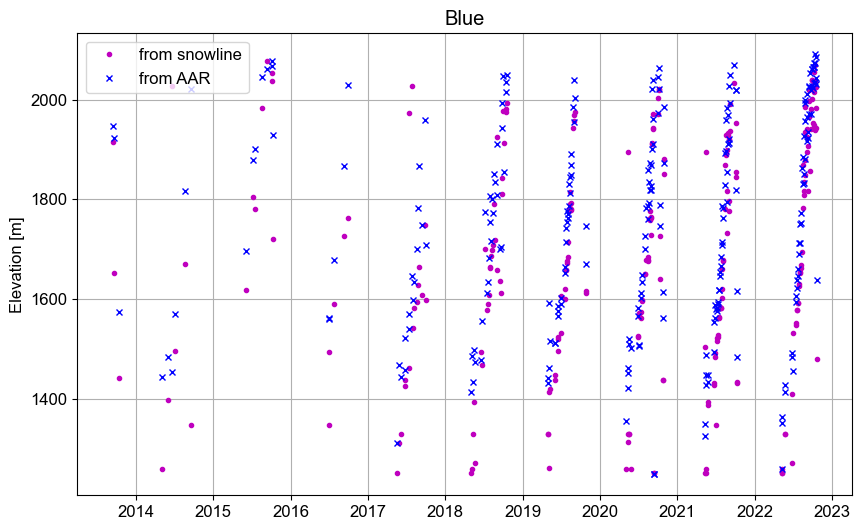

In [45]:
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})

# iterate over site names
for site_name in site_names[0:5]:
        
    # define paths in directory
    snowlines_path = study_sites_path + site_name + '/imagery/snowlines/'
    
    # load snowline and classified image file names
    snowline_fns = [os.path.basename(x) for x in glob.glob(snowlines_path + '*.csv')]
    
    # iterate over snowline files
    snowlines = pd.DataFrame()
    for snowline_fn in snowline_fns:
                
        # load snowline
        try:
            snowline = pd.read_csv(snowlines_path + snowline_fn)
            snowlines = pd.concat([snowlines, snowline])
        except:
            continue
    
    snowlines.reset_index(drop=True, inplace=True)
    snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
    
    # plot
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(snowlines['datetime'], snowlines['snowline_elevs_median_m'], '.m', label='from snowline')
    ax.plot(snowlines['datetime'], snowlines['ELA_from_AAR_m'], 'xb', markersize=5, label='from AAR')
    ax.grid()
    ax.set_title(site_name)
    ax.legend(loc='upper left')
    ax.set_ylabel('Elevation [m]')
    plt.show()
    
    # fig.savefig('ELAs_' + site_name + '.png')
    